## 0. Import Libraries

For ease of use and ram, run each indices in different sessions

In [23]:
import climextremes
import numpy as np
import pandas as pd
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

## 1. Data Options

In [3]:
# change these
season = 'JJA' # DJF, JJA,
time_resample = 6 # options: 1, 3, 6 (resampling)

# bias algorithm
bias_algo = 'QDM'

# path for resampling information
if time_resample != 1:
    path_resample = fr'{time_resample}hrsum'
else:
    path_resample = fr'{time_resample}hr'
    
# general data path
path_general = fr'/mnt/d/JupyterLab/Yuksek_Lisans/msc_thesis_data'

# variable name
name_variable_cosmo = 'TOT_PREC'

# saving path (saving with cosmo var name for both era5 and cosmo)
path_save = fr'data/{name_variable_cosmo}/'

# years
years = np.arange(1985, 2006, dtype=int)

## 2. Intensity Indices

### 2.1 Open Data

In [9]:
intensity_indice_name = fr'rx{time_resample}hr'
intensity_idx_cosmo = xr.open_dataset(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{intensity_indice_name}_198501_200512.nc")[name_variable_cosmo]

In [14]:
# get the attributes in a dict
intensity_indice_attrs = intensity_idx_cosmo.attrs

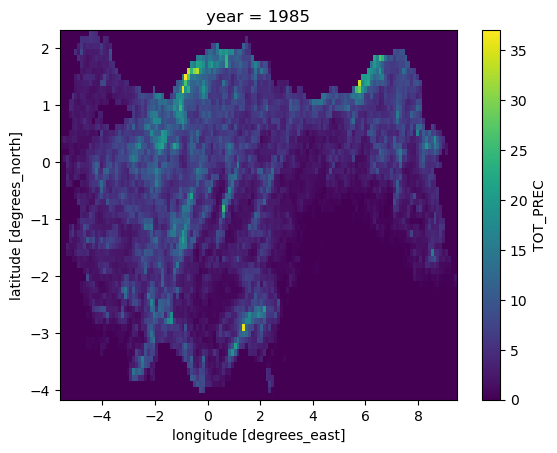

In [21]:
intensity_idx_cosmo[0].plot()

In [88]:
dt_test = intensity_idx_cosmo.sel(rlat=slice(0.5, 1),
                        rlon=slice(-2, -1)).stack(horizontal = ('rlat', 'rlon')).values[:, 0:2]

In [90]:
replicate_index = np.arange(1,22).repeat(len(dt_test[0]))

In [92]:
np.shape(dt_test)

(21, 2)

In [96]:
intensity_model = climextremes.fit_gev(y=dt_test.transpose().flatten(),
                                       nReplicates=2,
                                       #replicateIndex=replicate_index,
                                       returnPeriod = 20,
                                       getParams = True,
                                       bootSE = True,
                                       getFit = True,
                                         )

In [97]:
intensity_model

{'mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'mle': array([5.63479546, 3.38287419, 0.07523291]),
 'se_mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'se_mle': array([0.58386213, 0.43139513, 0.10865081]),
 'nllh': array([119.19581231]),
 'returnValue': array([16.8937218]),
 'se_returnValue': array([2.27330785]),
 'info': {'convergence': array([0], dtype=int32),
  'counts_names': array(['function', 'gradient'], dtype='<U8'),
  'counts': array([70., nan]),
  'message': None,
  'failure': array([0], dtype=int32)},
 'fit': {'call': Rlang( fevd(x = .y ~ 1, data = x, location.fun = locationFun, scale.fun = scaleFun,  ),
  'data.name': array(['.y ~ 1', 'x'], dtype='<U6'),
  'weights': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1.]),
  'in.data': array([1], dtype=int32),
  'x.fun': None,
  'missing.values_names'

In [95]:
intensity_model

{'mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'mle': array([5.63479546, 3.38287419, 0.07523291]),
 'se_mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'se_mle': array([0.58386213, 0.43139513, 0.10865081]),
 'nllh': array([119.19581231]),
 'returnValue': array([16.8937218]),
 'se_returnValue': array([2.27330785]),
 'info': {'convergence': array([0], dtype=int32),
  'counts_names': array(['function', 'gradient'], dtype='<U8'),
  'counts': array([70., nan]),
  'message': None,
  'failure': array([0], dtype=int32)},
 'fit': {'call': Rlang( fevd(x = .y ~ 1, data = x, location.fun = locationFun, scale.fun = scaleFun,  ),
  'data.name': array(['.y ~ 1', 'x'], dtype='<U6'),
  'weights': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1.]),
  'in.data': array([1], dtype=int32),
  'x.fun': None,
  'missing.values_names'

## Extra

In [61]:
np.shape(np.array([[1,2,3],
         [4,5,6]]))

(2, 3)

In [71]:
np.array([[1,2,3],
         [4,5,6]]).transpose().flatten()

array([1, 4, 2, 5, 3, 6])